# Example Implementation of Image Reception from Users, License Plate Detection, and Optical Character Recognition Using OpenCV and Building a Convolutional Neural Network Based on Keras
Annotation: This work demonstrates the process of image processing, which includes receiving images from users, detecting and extracting license plates from the images, as well as optical character recognition (OCR) for identifying the text on the license plate. The tools used for this purpose are OpenCV and Python. Additionally, the work describes the construction of a convolutional neural network (CNN) based on Keras, which was trained on a small dataset containing 864 images, distributed across 36 classes of license plate characters.

# License Plate Detection and Display of Each Character Using OpenCV

In [2]:
## Loading Necessary Librarie

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

## Loading and Preparing Data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


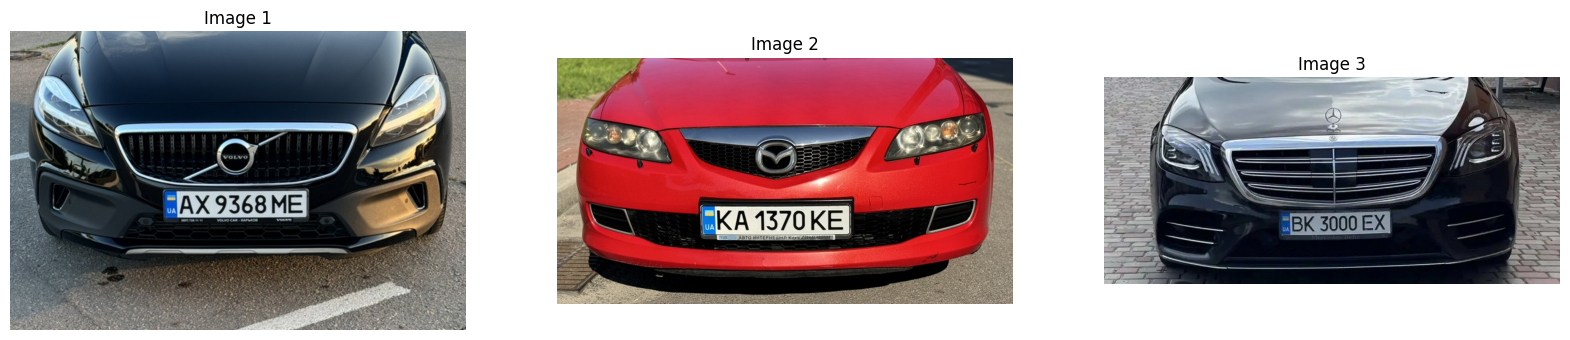

In [9]:
# Function to Display an Image
def display_image(img, title=""):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

# Connecting Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Loading Images
image_folder = '/content/drive/MyDrive/Drive/data/Images'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]

# Displaying All Images
plt.figure(figsize=(20, 10))
for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path)
    plt.subplot(1, len(image_files), i + 1)
    display_image(image, f"Image {i+1}")
plt.show()


## Displaying Images with Bounded License Plates

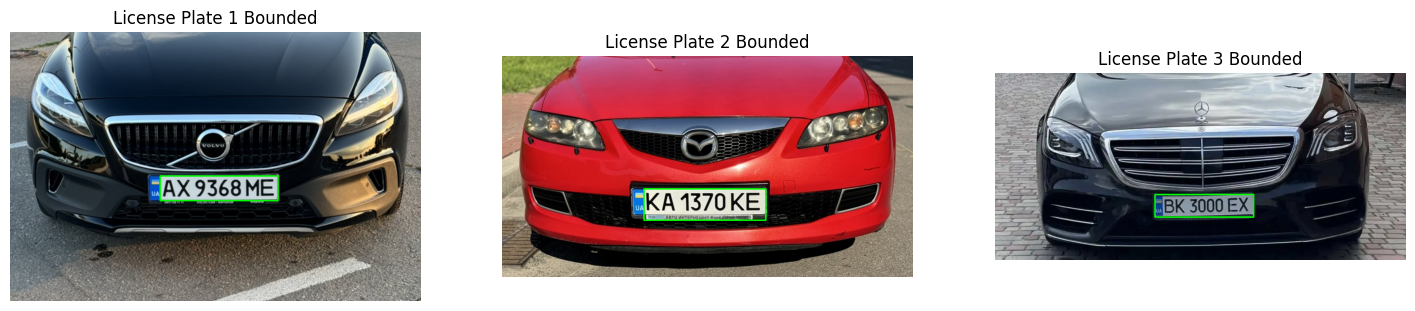

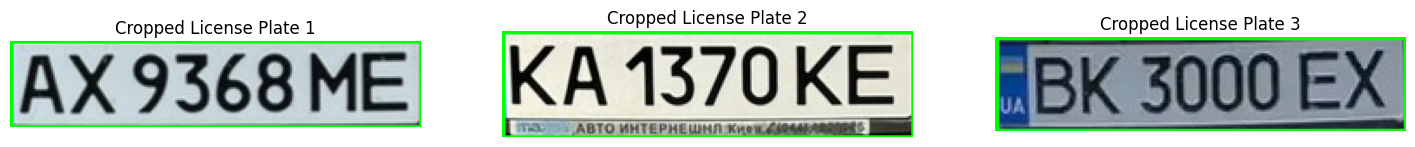

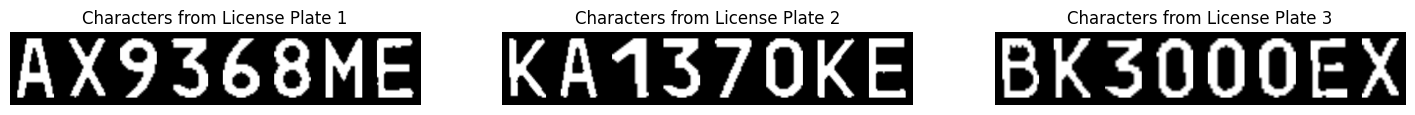

In [16]:
# Displaying Images with Bounded License Plates
fig2, axs2 = plt.subplots(1, len(image_files), figsize=(18, 4))
fig3, axs3 = plt.subplots(1, len(image_files), figsize=(18, 4))
fig4, axs4 = plt.subplots(1, len(image_files), figsize=(18, 4))

char = []  # Variable to store all extracted characters

for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path)

    # Converting to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    height, width = edges.shape
    roi = edges[int(height*0.5):height, 0:width]
    contours, _ = cv2.findContours(roi, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    plate_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(contour)

        if 1500 < area < 15000 and 2.0 < aspect_ratio < 5.5:
            if 300 > w > 100 and 120 > h > 40:
                plate_contours.append((x, y, w, h))

    if plate_contours:
        x, y, w, h = max(plate_contours, key=lambda item: item[2] * item[3])
        y += int(height*0.5)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        axs2[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs2[i].axis("off")
        axs2[i].set_title(f"License Plate {i+1} Bounded")

        cropped_plate = image[y:y + h, x:x + w]
        axs3[i].imshow(cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2RGB))
        axs3[i].axis("off")
        axs3[i].set_title(f"Cropped License Plate {i+1}")

        # Preprocessing the Cropped License Plate
        binary_plate = cv2.threshold(cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2GRAY), 200, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        contours, _ = cv2.findContours(binary_plate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        char_contours = []

        for contour in contours:
            cx, cy, cw, ch = cv2.boundingRect(contour)
            aspect_ratio = cw / float(ch)
            area = cv2.contourArea(contour)
            if 120 > ch > 20 and 0.1 < aspect_ratio < 1.0 and area > 80:
                char_contours.append((cx, cy, cw, ch))


        char_contours = sorted(char_contours, key=lambda b: b[0])

        # Displaying Each Character Separately
        all_chars = []
        for (cx, cy, cw, ch) in char_contours:
            char_img = binary_plate[cy:cy + ch, cx:cx + cw]
            char_img_resized = cv2.resize(char_img, (50, 80))
            char_img_padded = cv2.copyMakeBorder(char_img_resized, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 0])
            all_chars.append(char_img_padded)
            char.append(char_img_padded)

        final_chars = np.hstack(all_chars)
        axs4[i].imshow(final_chars, cmap='gray')
        axs4[i].axis('off')
        axs4[i].set_title(f"Characters from License Plate {i+1}")

plt.show()

# Building a Convolutional Neural Network with Keras

## Загружаем необхідні бібліотеки

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

## Loading Data for Training and Validation

In [18]:
# Configuring Image Data Generators for Training and Validation Data
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.05, height_shift_range=0.05)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Drive/data/train',
    target_size=(28,28),  # Image Size
    batch_size=32,        # Batch Size
    class_mode='categorical'  # Categorical Classification
)

validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Drive/data/val',
    target_size=(28,28),
    batch_size=32,
    class_mode='categorical'
)


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


## Defining Callbacks for Early Stopping and TensorBoard

In [19]:
# Callback for Early Stopping if Validation Accuracy Exceeds 99.2%
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc > 0.992:
            self.model.stop_training = True

# TensorBoard Callback to Monitor Training Process
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


## Building and Compiling the Model

In [20]:
# Building and Compiling the Model
from tensorflow.keras.layers import Input

model = Sequential([
    Input(shape=(28, 28, 3)),
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=36, activation='softmax')
])

# Compiling the Model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

## Training the Model

In [21]:
# Training the Model
batch_size = 32
callbacks = [tensorboard_callback, stop_training_callback()]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 176s 5s/step - accuracy: 0.0375 - loss: 3.6001 - val_accuracy: 0.0573 - val_loss: 3.5656
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0833 - val_loss: 3.5601
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.0682 - loss: 3.5569 - val_accuracy: 0.0938 - val_loss: 3.5247
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1667 - val_loss: 3.5147
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.1126 - loss: 3.5176 - val_accuracy: 0.1927 - val_loss: 3.4655
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1667 - val_loss: 3.4973
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.1807 - loss: 3.4585 - val_accuracy: 0.2500 - val_loss: 3.3964
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3333 - val_loss: 3.3532
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.2846 - loss: 3.

## Creating Graphs to Display Losses and Accuracy During Training and Validation

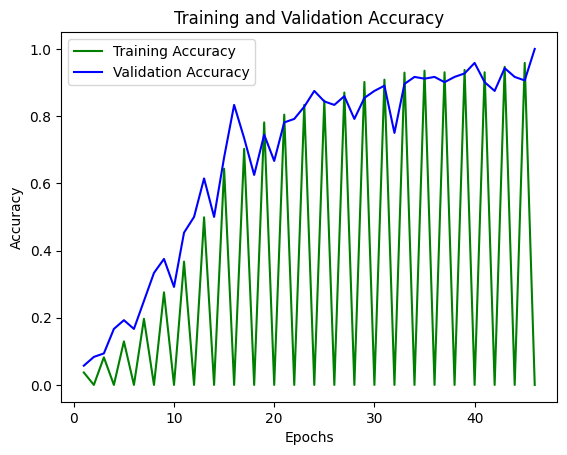

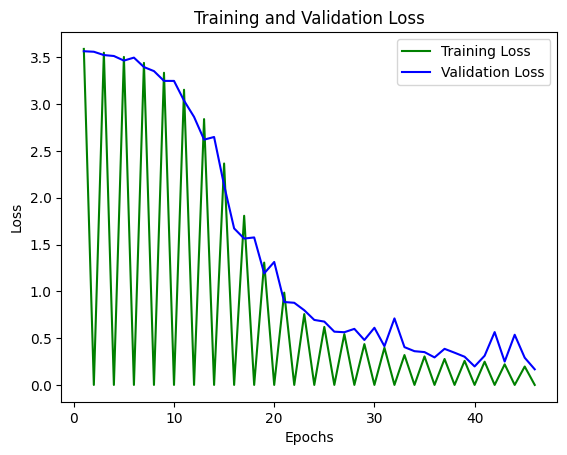

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Побудова графіку точності
plt.plot(epochs, acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')  #
plt.ylabel('Accuracy')
plt.show()

# Побудова графіку втрат
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')  #
plt.title('Training and Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Evaluating the Model on the Validation Set

In [23]:
# Evaluating the Model on Validation Data
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.8950 - loss: 0.3772
Test Loss: 0.31283828616142273
Test Accuracy: 0.9166666865348816


## Saving the Model

In [24]:
# Saving the Model in Keras Format
model.save("/content/drive/MyDrive/Drive/model.keras")


## Predicting Results

Predicted Result for Vehicle 1: AX5J68HE
Predicted Result for Vehicle 2: KA1J7OKE
Predicted Result for Vehicle 3: 8KJ000EX


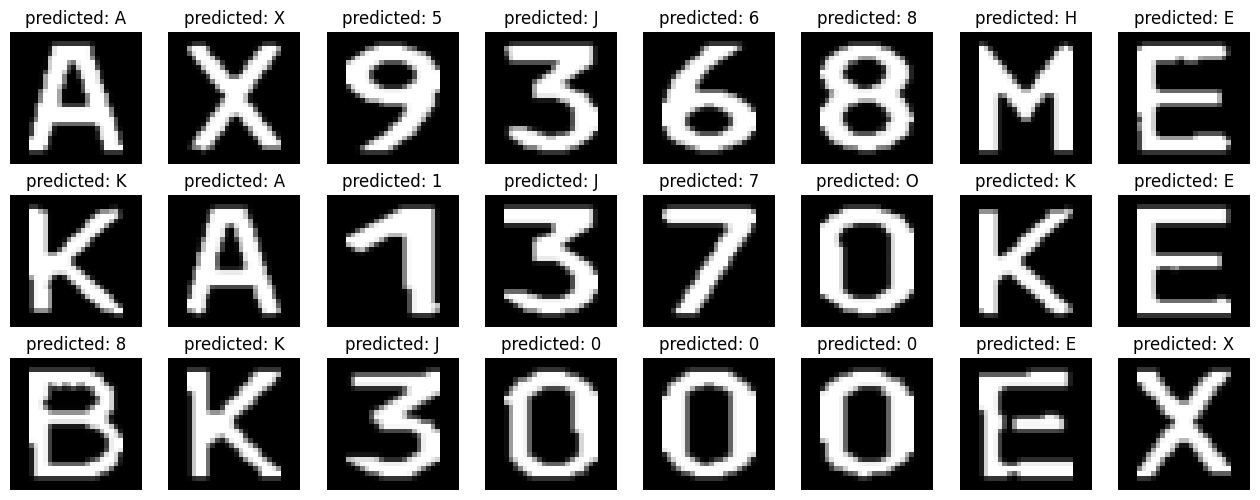

In [25]:
# Functions to Prepare Images and Predict Characters

def fix_dimension(img):
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char):
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)
        y_proba = model.predict(img, verbose=0)[0]
        y_ = np.argmax(y_proba)
        character = dic[y_]
        output.append(character)

    plate_number = ''.join(output)
    return plate_number

# Displaying Predicted Results for Each Vehicle
for i in range(len(image_files)):
    plate_number = show_results(char[i * 8:(i + 1) * 8])
    print(f"Predicted Result for Vehicle {i+1}: {plate_number}")

num_chars = len(char)
cols =  8
rows = (num_chars + cols - 1) // cols

plt.figure(figsize=(cols * 2, rows * 2))
for i, ch in enumerate(char):
    img = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap='gray')
    predicted_char = show_results([ch])[0]
    plt.title(f'predicted: {predicted_char}')
    plt.axis('off')
plt.show()


# Conclusion:
<p> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This notebook_example serves as an example of implementing image reception from users, license plate detection, and optical character recognition using OpenCV, along with building a convolutional neural network based on Keras. The custom neural network was trained on a limited dataset of only 864 images spread across 36 classes of license plate symbols. Due to the small training set, the network's performance was hindered, particularly under varying lighting conditions and different angles. While this approach demonstrates the basics of implementing a neural network for license plate recognition, more powerful and accurate tools, such as YOLO, SORT, and EasyOCR, offer enhanced accuracy and reliability for real-world applications.<p>
<p> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; In this project, we implemented a robust solution for license plate recognition by combining several advanced techniques. YOLO was employed for accurate vehicle detection, while SORT (Simple Online and Realtime Tracking) ensured the consistency of detected objects across video frames. SORT, utilizing a Kalman filter-based tracker, allowed for reliable tracking even when objects briefly disappeared from the frame. For character recognition, EasyOCR was selected due to its simplicity and high accuracy.This comprehensive approach—integrating detection, tracking, and recognition—proved to be effective in addressing the challenges of license plate recognition in dynamic environmentю.<p>